
# Imported Libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

import numpy as np
import sys

import seaborn as sns
import scipy.misc
import cv2

sys.path.insert(0, "../src/")
import constants as c
from copy import copy
from random import shuffle
from batch_generator import CarvanaBatchGenerator

from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.layers.normalization import BatchNormalization
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


# Problem Evaluation Function Definition

In [2]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Model Definition

In [3]:
def get_unet(img_rows, img_cols):
    inputs = Input((img_rows, img_cols, 3))
    conv1 = BatchNormalization()(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = BatchNormalization()(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss='binary_crossentropy', metrics=[dice_coef])

    return model

In [4]:
SCALING_FACTOR=0.1
SIZE_h=int(round(1280*SCALING_FACTOR))
SIZE_w=int(round(1280*SCALING_FACTOR))
params = {
    'dim_x': SIZE_w,
    'dim_y': SIZE_h,
    'batch_size': 1,
    'shuffle': True,
    'mode':'Train'
         }

train_val_split = 0.8
n_samples = len(c.train_ids)
samples = copy(c.train_ids)
split_id = int(n_samples*train_val_split)
shuffle(samples)

generator = CarvanaBatchGenerator(**params).generate(samples[:split_id])

In [5]:
see=generator.next()
print(see[0].shape)
print(see[1].shape)

(1, 128, 128, 3)
(1, 128, 128, 1)


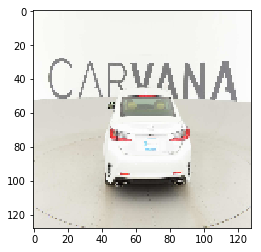

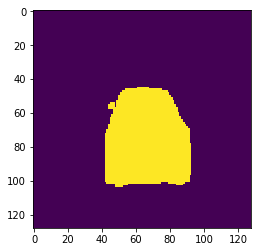

In [6]:
import matplotlib.pyplot as plt
plt.imshow(see[0].reshape(see[0].shape[1],see[0].shape[2],3))
plt.show()
plt.imshow(see[1].reshape(see[0].shape[1],see[0].shape[2]))
plt.show()

# Checkpointing Definition

In [7]:
model_checkpoint = ModelCheckpoint('../weights/weights.h5', monitor='val_loss', save_best_only=True)

In [ ]:
model = get_unet(SIZE_w, SIZE_h)
params = {
    'dim_x': SIZE_w,
    'dim_y': SIZE_h,
    'batch_size': 1,
    'shuffle': True,
    'mode':'Train'
         }

train_val_split = 0.8
n_samples = len(c.train_ids)
samples = copy(c.train_ids)
split_id = int(n_samples*train_val_split)
shuffle(samples)


training_generator = CarvanaBatchGenerator(**params).generate(samples[:split_id])
validation_generator = CarvanaBatchGenerator(**params).generate(samples[split_id:])

In [ ]:
model.fit_generator(training_generator,
                    steps_per_epoch = len(samples[:split_id])//params['batch_size'],
                    validation_data = validation_generator,
                    validation_steps = len(samples[split_id:])//params['batch_size'],
                    epochs = 10,
                    verbose = 1,
                    callbacks = [model_checkpoint],
                    nb_worker = 1)

/home/gpuserver/gcarita/virtual/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/home/gpuserver/gcarita/virtual/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, workers=1, validation_data=<generator..., steps_per_epoch=4070, epochs=10, callbacks=[<keras.ca..., validation_steps=1018)`
  


Epoch 1/10
4070/4070 [==============================] - 217s - loss: 0.0273 - dice_coef: 0.0263 - val_loss: 0.0056 - val_dice_coef: 0.0394
Epoch 2/10
4070/4070 [==============================] - 208s - loss: 0.0055 - dice_coef: 0.0402 - val_loss: 0.0056 - val_dice_coef: 0.0443
Epoch 3/10
4070/4070 [==============================] - 207s - loss: 0.0055 - dice_coef: 0.0409 - val_loss: 0.0056 - val_dice_coef: 0.0408
Epoch 4/10
2055/4070 [==============>...............] - ETA: 86s - loss: 0.0054 - dice_coef: 0.0410

KeyboardInterrupt: 

In [ ]:
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
model.fit_generator(training_generator,
                    steps_per_epoch = len(samples[:split_id])//params['batch_size'],
                    validation_data = validation_generator,
                    validation_steps = len(samples[split_id:])//params['batch_size'],
                    epochs = 40,
                    verbose = 1,
                    callbacks = [model_checkpoint],
                    nb_worker = 1)

/home/gpuserver/gcarita/virtual/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/home/gpuserver/gcarita/virtual/lib/python2.7/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, workers=1, validation_data=<generator..., steps_per_epoch=4070, epochs=40, callbacks=[<keras.ca..., validation_steps=1018)`
  if __name__ == '__main__':


Epoch 1/40
4070/4070 [==============================] - 206s - loss: -0.0690 - dice_coef: 0.0690 - val_loss: -0.0709 - val_dice_coef: 0.0709
Epoch 2/40
 549/4070 [===>..........................] - ETA: 147s - loss: -0.0711 - dice_coef: 0.0711

In [ ]:
5